<a href="https://colab.research.google.com/github/Auhre/Churn-Modelling---Base/blob/main/Churn_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Components**

In [1]:
!pip install sdv

In [2]:
  import time
  import seaborn as sns
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.preprocessing import LabelEncoder, StandardScaler
  from sklearn.model_selection import train_test_split
  from sklearn.svm import SVC
  from sklearn.linear_model import LogisticRegression
  from xgboost import XGBClassifier
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
  from sdv.single_table import CTGANSynthesizer
  from sdv.metadata import SingleTableMetadata
  from scipy.stats import ks_2samp

In [3]:
class DataLoader:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path)

    def remove_columns(self, columns):
        self.df.drop(columns, axis=1, inplace=True)
        removed_columns = ', '.join(columns)
        print(f'Columns {removed_columns} removed.')

    def print_dataframe(self):
        print('Current DataFrame:')
        print('--------------------------------')
        print(self.df.head())

    def get_data(self):
        print('DataFrame retrieved.')
        return self.df

In [4]:
class FeatureMonitoring:
    def __init__(self, df):
        self.df = df.copy()

    def plot_features_histogram(self, excluded_cols):
        features = [col for col in self.df.columns if col not in excluded_cols]
        rows = 3
        cols = 3
        fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
        fig.suptitle('Histograms of Features', fontsize=16, y=1.05)

        for i, feature in enumerate(features[:rows*cols]):
            row = i // cols
            col = i % cols
            ax = axes[row, col]
            n, bins, patches = ax.hist(self.df[feature], bins=20)
            for patch in patches:
                patch.set_width( (bins[1] - bins[0]) * 0.9 )
            ax.set_title(feature)
            ax.set_xlabel(feature)
            ax.set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

    def calculate_data_drift(self, new_df):
        drift_report = {}
        for column in self.df.columns:
            if column in new_df.columns:
                stat, p_value = ks_2samp(self.df[column], new_df[column])
                drift_report[column] = {
                    'KS Statistic': stat,
                    'P-value': p_value,
                    'Drift Detected': p_value < 0.05
                }

        print('Data Drift Analysis:')
        print('--------------------------------')
        print(pd.DataFrame(drift_report).T)

    def target_variable_distribution(self, df, target_var):
        df_0 = df[df[target_var] == 0]
        df_1 = df[df[target_var] == 1]

        print('Distribution of Target Variable:')
        print('--------------------------------')
        print(f'Category 0 has {len(df_0)} entries')
        print(f'Category 1 has {len(df_1)} entries')

    def plot_data_drift_on_features(self, new_df, excluded_cols):
      features = [col for col in self.df.columns if col not in excluded_cols]
      rows = 3
      cols = 3
      fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
      fig.suptitle('Data Drift on Features', fontsize=16, y=1.05)

      for i, column in enumerate(features[:rows*cols]):
        row = i // cols
        col = i % cols
        ax = axes[row, col]

        sns.histplot(self.df[column], ax=ax, kde=True, label='Original Data', color='blue')
        sns.histplot(new_df[column], ax=ax, kde=True, label='New Data', color='orange')

        ax.set_title(column)
        ax.legend()

      plt.tight_layout()
      plt.show()


In [5]:
class FourModelClassification:
    def __init__(self, df, target_var):
        self.X = None
        self.y = None
        self.encoder = None
        self.scaler = None
        self.numerical_features = None
        self.categorical_features = None
        self.X_test = None
        self.y_test= None
        self.svm_model = None
        self.logistic_model = None
        self.xgboost_model = None
        self.random_forest_model = None
        self.svm_predictions = None
        self.logistic_predictions = None
        self.xgboost_predictions = None
        self.random_forest_predictions = None
        self.best_model = None
        self.predictor_models = None
        self.svm_accuracy, self.svm_precision, self.svm_recall, self.svm_f1 = None, None, None, None
        self.logistic_accuracy, self.logistic_precision, self.logistic_recall, self.logistic_f1 = None, None, None, None
        self.xgboost_accuracy, self.xgboost_precision, self.xgboost_recall, self.xgboost_f1 = None, None, None, None
        self.rf_accuracy, self.rf_precision, self.rf_recall, self.rf_f1 = None, None, None, None
        self.df = df.copy()
        self.target_var = target_var

    def imbalance_handler(self):
        import warnings
        warnings.filterwarnings("ignore")

        value_counts_target = self.df[self.target_var].value_counts()
        max = 9000
        to_fill = {
            0: max - value_counts_target[0],
            1: max - value_counts_target[1]
        }

        start_time = time.time()

        metadata = SingleTableMetadata()
        metadata.detect_from_dataframe(data=df)

        model = CTGANSynthesizer(metadata=metadata)
        model.fit(df)

        synthetic_data = model.sample(num_rows=25000)
        sythetic_0 = synthetic_data[synthetic_data[self.target_var] == 0].head(to_fill[0])
        synthetic_1 = synthetic_data[synthetic_data[self.target_var] == 1].head(to_fill[1])
        synthetic_df = pd.concat([sythetic_0, synthetic_1], ignore_index=True)

        end_time = time.time()
        execution_time = end_time - start_time
        print(f'Completed balancing of class within {execution_time:.4f} seconds')

        self.df = pd.concat([self.df, synthetic_df], ignore_index=True)
        return self.df

    def preprocess(self):
        self.encoder = LabelEncoder()
        self.scaler = StandardScaler()

        self.numerical_features = self.df.select_dtypes(include=['int']).columns.tolist() + self.df.select_dtypes(include=['float']).columns.tolist()
        self.categorical_features = self.df.select_dtypes(include=['object']).columns.tolist()

        self.numerical_features = [col for col in self.numerical_features if col != self.target_var]
        self.categorical_features = self.categorical_features[0] if len(self.categorical_features) == 1 else self.categorical_features

        self.df[self.categorical_features] = self.encoder.fit_transform(self.df[self.categorical_features])
        self.df[self.numerical_features] = self.scaler.fit_transform(self.df[self.numerical_features])
        self.X = self.df.drop(self.target_var, axis=1)
        self.y = self.df[self.target_var]

        print('X Features:')
        print('--------------------------------')
        print(self.X)

        print('Y Targets:')
        print('--------------------------------')
        print(self.y)

    def training(self, test_size, random_state):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=random_state)
        self.X_test = X_test
        self.y_test= y_test

        self.svm_model = SVC()
        self.logistic_model = LogisticRegression()
        self.xgboost_model = XGBClassifier()
        self.random_forest_model = RandomForestClassifier()

        self.predictor_models = {
            'SVM': self.svm_model,
            'Logistic Regression': self.logistic_model,
            'XGBoost': self.xgboost_model,
            'Random Forest': self.random_forest_model
        }

        training_times = {}
        inference_times = {}

        for model_name, model in self.predictor_models.items():
            start_time = time.time()
            model.fit(X_train, y_train)
            end_time = time.time()
            training_times[model_name] = end_time - start_time

            start_time = time.time()
            model.predict(self.X_test)
            end_time = time.time()
            inference_times[model_name] = end_time - start_time

        self.generate_metric_predictions()

        model_training_time = pd.DataFrame.from_dict(training_times, orient='index', columns=['value'])
        model_inference_time = pd.DataFrame.from_dict(inference_times, orient='index', columns=['value'])
        model_training_time = model_training_time.rename(columns={'value': 'Training Time (secs)'})
        model_inference_time = model_inference_time.rename(columns={'value': 'Inference Time (secs)'})
        model_execution_time = pd.concat([model_training_time, model_inference_time], axis=1)

        return model_execution_time

    def generate_metric_predictions(self):
        self.predictor_models = {
            'SVM': self.svm_model,
            'Logistic Regression': self.logistic_model,
            'XGBoost': self.xgboost_model,
            'Random Forest': self.random_forest_model
        }

        self.svm_predictions = self.svm_model.predict(self.X_test)
        self.logistic_predictions = self.logistic_model.predict(self.X_test)
        self.xgboost_predictions = self.xgboost_model.predict(self.X_test)
        self.random_forest_predictions = self.random_forest_model.predict(self.X_test)

    def evaluation_metrics(self):
        def calculate_metrics(y_true, y_pred):
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            return accuracy, precision, recall, f1

        print("SVM Model:")
        self.svm_accuracy, self.svm_precision, self.svm_recall, self.svm_f1 = calculate_metrics(self.y_test, self.svm_predictions)
        print(f"Accuracy: {self.svm_accuracy:.4f}, Precision: {self.svm_precision:.4f}, Recall: {self.svm_recall:.4f}, F1-Score: {self.svm_f1:.4f}")

        print("\nLogistic Regression Model:")
        self.logistic_accuracy, self.logistic_precision, self.logistic_recall, self.logistic_f1 = calculate_metrics(self.y_test, self.logistic_predictions)
        print(f"Accuracy: {self.logistic_accuracy:.4f}, Precision: {self.logistic_precision:.4f}, Recall: {self.logistic_recall:.4f}, F1-Score: {self.logistic_f1:.4f}")

        print("\nXGBoost Model:")
        self.xgboost_accuracy, self.xgboost_precision, self.xgboost_recall, self.xgboost_f1 = calculate_metrics(self.y_test, self.xgboost_predictions)
        print(f"Accuracy: {self.xgboost_accuracy:.4f}, Precision: {self.xgboost_precision:.4f}, Recall: {self.xgboost_recall:.4f}, F1-Score: {self.xgboost_f1:.4f}")

        print("\nRandom Forest Model:")
        self.rf_accuracy, self.rf_precision, self.rf_recall, self.rf_f1 = calculate_metrics(self.y_test, self.random_forest_predictions)
        print(f"Accuracy: {self.rf_accuracy:.4f}, Precision: {self.rf_precision:.4f}, Recall: {self.rf_recall:.4f}, F1-Score: {self.rf_f1:.4f}")

    def performance_monitoring(self):
        models = ['SVM', 'Logistic Regression', 'XGBoost', 'Random Forest']
        accuracy_scores = [self.svm_accuracy, self.logistic_accuracy, self.xgboost_accuracy, self.rf_accuracy]
        precision_scores = [self.svm_precision, self.logistic_precision, self.xgboost_precision, self.rf_precision]
        recall_scores = [self.svm_recall, self.logistic_recall, self.xgboost_recall, self.rf_recall]
        f1_scores = [self.svm_f1, self.logistic_f1, self.xgboost_f1, self.rf_f1]

        x = np.arange(len(models))
        width = 0.2

        fig, ax = plt.subplots(figsize=(12, 6))
        rects1 = ax.bar(x - 1.5 * width, accuracy_scores, width, label='Accuracy')
        rects2 = ax.bar(x - 0.5 * width, precision_scores, width, label='Precision')
        rects3 = ax.bar(x + 0.5 * width, recall_scores, width, label='Recall')
        rects4 = ax.bar(x + 1.5 * width, f1_scores, width, label='F1-Score')

        ax.set_xlabel('Models')
        ax.set_ylabel('Scores')
        ax.set_title('Model Performance Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(models)
        ax.legend()

        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate('{:.3f}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)
        autolabel(rects3)
        autolabel(rects4)

        fig.tight_layout()
        plt.show()

    def roc_curve(self):
        plt.subplots(figsize=(10, 8))

        for model_name, model in self.predictor_models.items():
            if model_name in ['SVM']:
                y_prob = model.decision_function(self.X_test)
            else:
                y_prob = model.predict_proba(self.X_test)[:, 1]
            fpr, tpr, _ = roc_curve(self.y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for Different Models')
        plt.legend(loc='lower right')
        plt.show()
        return plt

    def confustion_matrix(self):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Confusion Matrices for Different Models', fontsize=16)

        models = [
            ('SVM', self.svm_predictions),
            ('Logistic Regression', self.logistic_predictions),
            ('Random Forest', self.xgboost_predictions),
            ('XGBoost', self.random_forest_predictions)
        ]

        for i, (model_name, y_pred) in enumerate(models):
            cm = confusion_matrix(self.y_test, y_pred)
            row = i // 2
            col = i % 2
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[row, col], cmap='Blues')
            axes[row, col].set_title(f'Confusion Matrix - {model_name}')
            axes[row, col].set_xlabel('Predicted Labels')
            axes[row, col].set_ylabel('True Labels')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()



    def know_best_model(self):
        model_performance = {
              'SVM': {'Accuracy': self.svm_accuracy, 'Precision': self.svm_precision, 'Recall': self.svm_recall, 'F1-Score': self.svm_f1},
              'Logistic Regression': {'Accuracy': self.logistic_accuracy, 'Precision': self.logistic_precision, 'Recall': self.logistic_recall, 'F1-Score': self.logistic_f1},
              'XGBoost': {'Accuracy': self.xgboost_accuracy, 'Precision': self.xgboost_precision, 'Recall': self.xgboost_recall, 'F1-Score': self.xgboost_f1},
              'Random Forest': {'Accuracy': self.rf_accuracy, 'Precision': self.rf_precision, 'Recall': self.rf_recall, 'F1-Score': self.rf_f1}
        }

        self.best_model = max(model_performance, key=lambda model: model_performance[model]['F1-Score'])
        print(f'The best model based on F1-score is: {self.best_model}')

    def predict(self, new_data):
        new_data[self.categorical_features] = self.encoder.transform(new_data[self.categorical_features])
        new_data[self.numerical_features] = self.scaler.transform(new_data[self.numerical_features])

        def append_to_dataset(predicted):
            new_data[self.target_var] = predicted
            self.df = pd.concat([self.df, new_data], ignore_index=True)

        model = self.predictor_models[self.best_model]
        prediction = model.predict(new_data)
        append_to_dataset(prediction[0])
        churn_prediction = "churn" if prediction[0] == 1 else "remain"
        print(f'Customer is highly likely to {churn_prediction}')

    def inverse_preprocess(self, df):
        new_df = df.copy()
        new_df[self.numerical_features] = self.scaler.inverse_transform(new_df[self.numerical_features])
        new_df[self.categorical_features] = self.encoder.inverse_transform(new_df[self.categorical_features])
        return new_df

## **Data Load**

In [6]:
dl = DataLoader('Churn_Modelling.csv')

In [7]:
dl.print_dataframe()

Current DataFrame:
--------------------------------
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57 

In [8]:
dl.remove_columns(['RowNumber', 'CustomerId', 'Surname', 'Geography'])

Columns RowNumber, CustomerId, Surname, Geography removed.


In [9]:
dl.print_dataframe()

Current DataFrame:
--------------------------------
   CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619  Female   42       2       0.00              1          1   
1          608  Female   41       1   83807.86              1          0   
2          502  Female   42       8  159660.80              3          1   
3          699  Female   39       1       0.00              2          0   
4          850  Female   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  
0               1        101348.88       1  
1               1        112542.58       0  
2               0        113931.57       1  
3               0         93826.63       0  
4               1         79084.10       0  


In [10]:
df = dl.get_data()

DataFrame retrieved.


In [11]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Female,43,2,125510.82,1,1,1,79084.10,0


## **Distribution from Features**

In [12]:
fm = FeatureMonitoring(df)

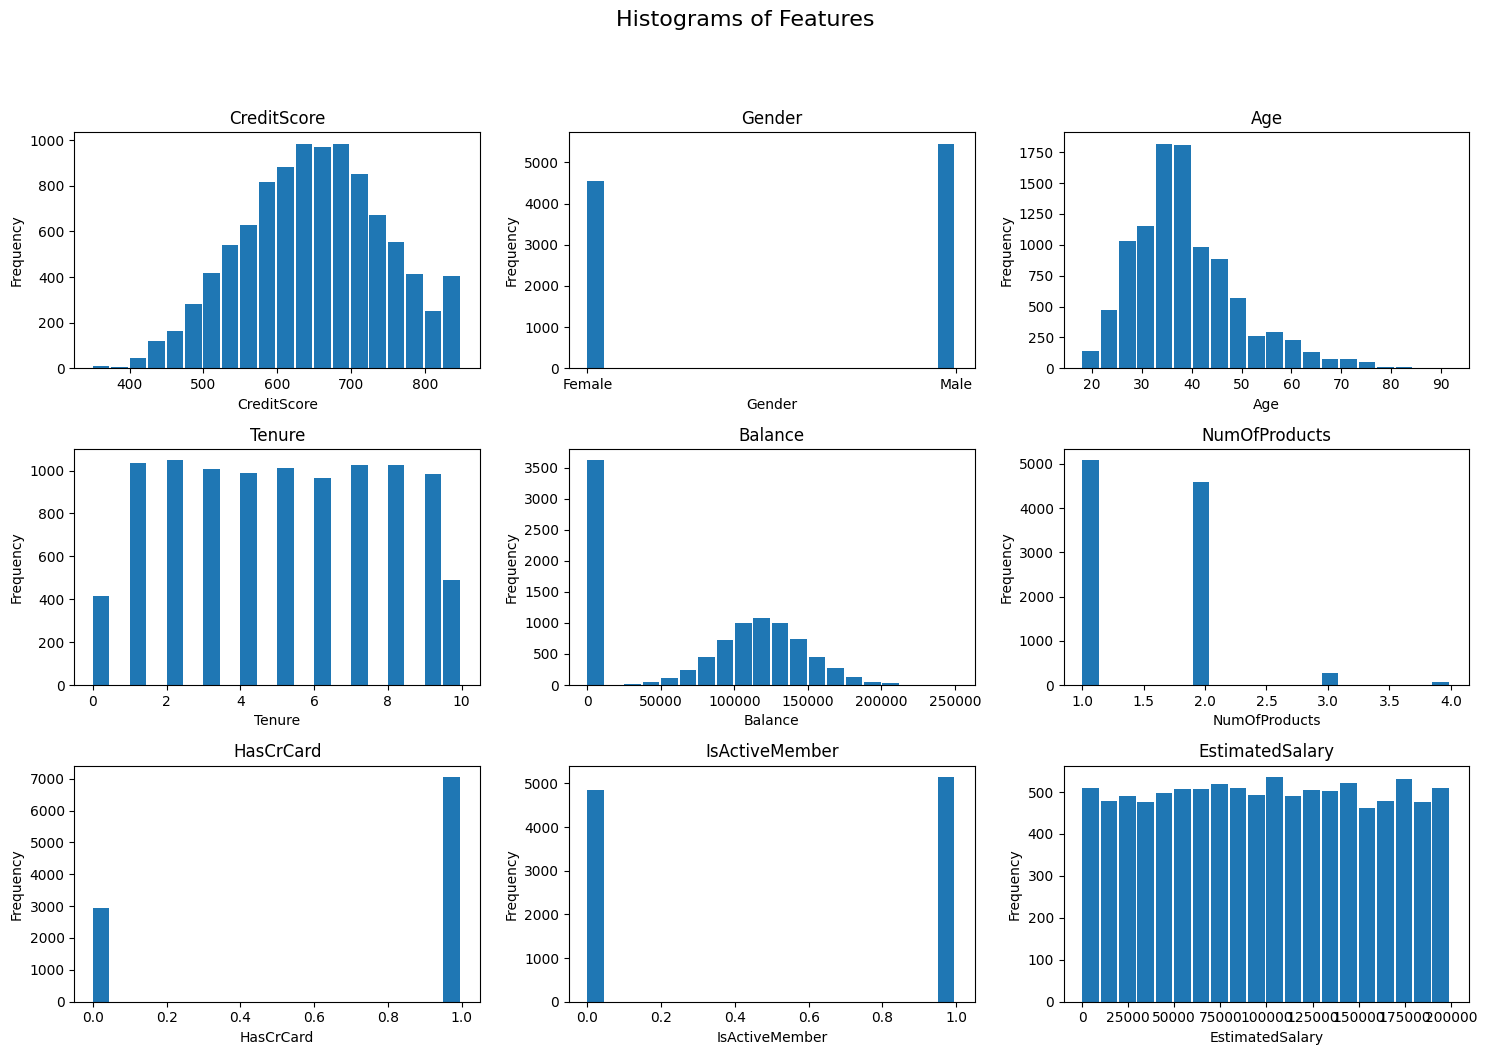

In [13]:
fm.plot_features_histogram(excluded_cols=['Exited'])

In [14]:
fm.target_variable_distribution(df, 'Exited')

Distribution of Target Variable:
--------------------------------
Category 0 has 7963 entries
Category 1 has 2037 entries


## **Modelling**

In [15]:
fmc = FourModelClassification(df, target_var='Exited')

In [16]:
completed_df = fmc.imbalance_handler()

Completed balancing of class within 507.3774 seconds


In [17]:
fmc.preprocess()

X Features:
--------------------------------
       CreditScore  Gender       Age    Tenure   Balance  NumOfProducts  \
0        -0.323877       0  0.041655 -0.942379 -1.294433      -0.755280   
1        -0.439076       0 -0.048007 -1.287878  0.079120      -0.755280   
2        -1.549176       0  0.041655  1.130613  1.322296       1.613891   
3         0.513934       0 -0.227330 -1.287878 -1.294433       0.429305   
4         2.095302       0  0.131317 -0.942379  0.762602      -0.755280   
...            ...     ...       ...       ...       ...            ...   
16595     1.498362       0  0.579625 -0.596880  1.222702      -0.755280   
16596     2.011521       1  1.476242 -0.596880  0.071724      -0.755280   
16597    -0.784673       1  0.758948  0.094117  0.297720       1.613891   
16598     0.053138       1  2.462521 -0.596880 -0.024358      -0.755280   
16599     0.681496       0 -0.675639  0.094117  0.071705      -0.755280   

       HasCrCard  IsActiveMember  EstimatedSalary  
0 

In [18]:
model_execution_time = fmc.training(test_size=0.2, random_state=42)
model_execution_time

,Training Time (secs),Inference Time (secs)
SVM,5.900997,2.093993
Logistic Regression,0.016717,0.002436
XGBoost,0.320127,0.014647
Random Forest,2.354447,0.063128


In [19]:
fmc.evaluation_metrics()

SVM Model:
Accuracy: 0.8196, Precision: 0.8234, Recall: 0.7507, F1-Score: 0.7854

Logistic Regression Model:
Accuracy: 0.7325, Precision: 0.6948, Recall: 0.6986, F1-Score: 0.6967

XGBoost Model:
Accuracy: 0.8117, Precision: 0.7967, Recall: 0.7678, F1-Score: 0.7820

Random Forest Model:
Accuracy: 0.8027, Precision: 0.7915, Recall: 0.7486, F1-Score: 0.7694


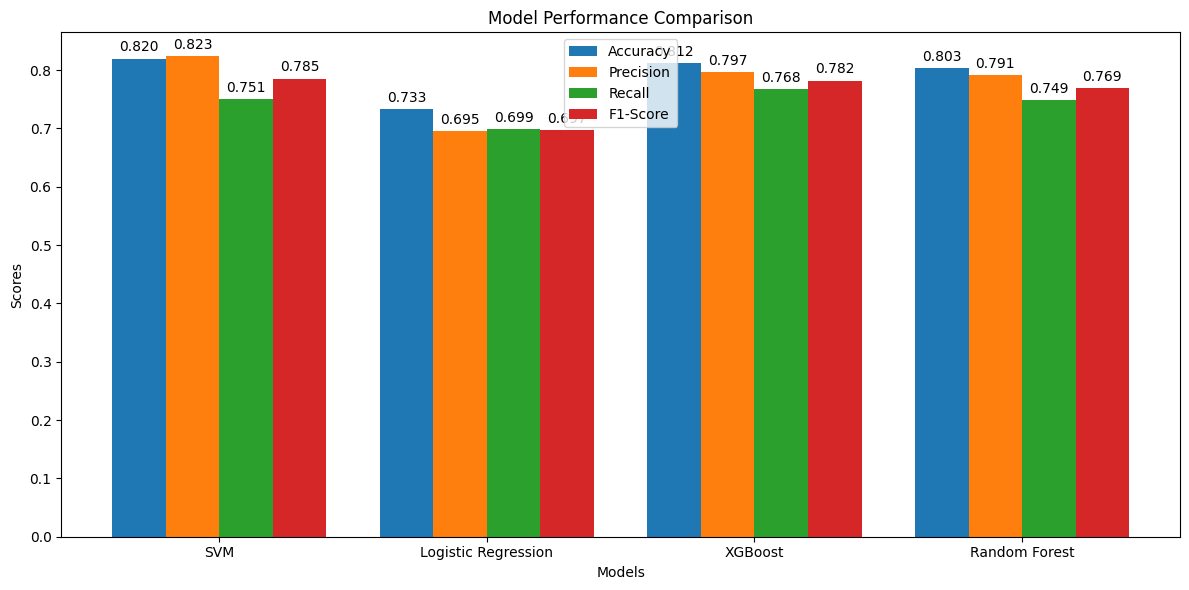

In [20]:
fmc.performance_monitoring()

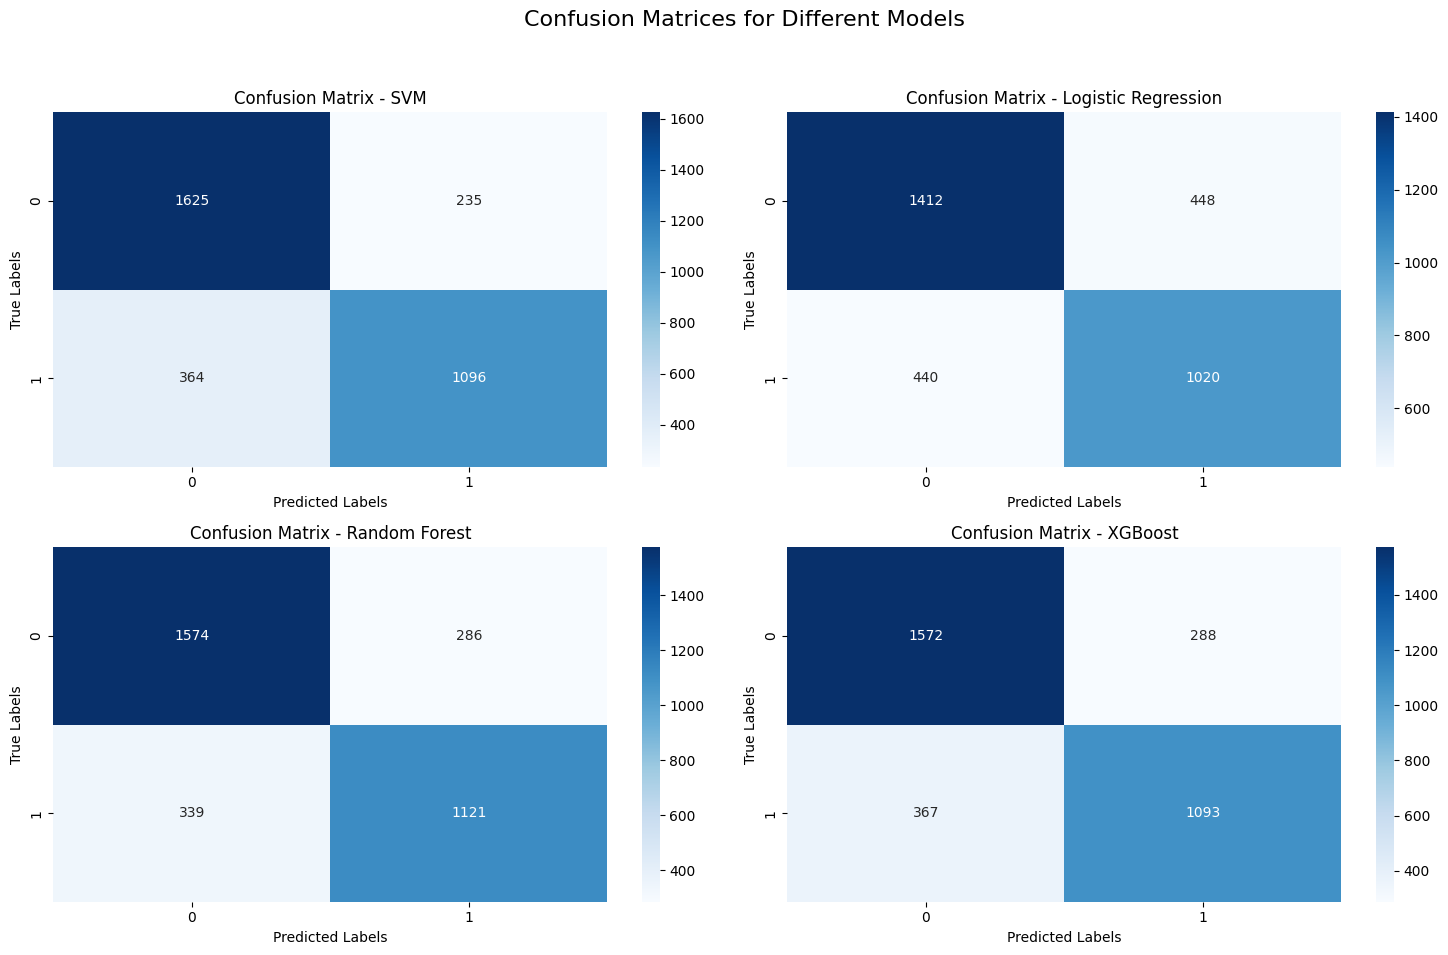

In [21]:
fmc.confustion_matrix()

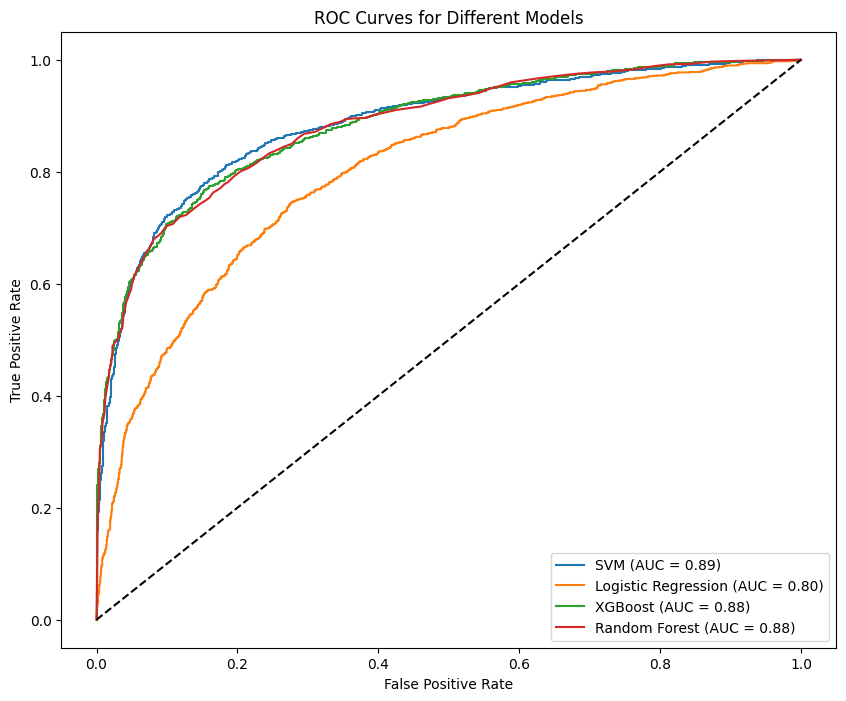

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [22]:
roc = fmc.roc_curve()
roc

In [23]:
fmc.know_best_model()

The best model based on F1-score is: SVM


In [24]:
new_data = pd.DataFrame({
    'CreditScore': [600],
    'Gender': ['Male'],
    'Age': [40],
    'Tenure': [3],
    'Balance': [60000],
    'NumOfProducts': [2],
    'HasCrCard': [1],
    'IsActiveMember': [1],
    'EstimatedSalary': [50000]
})
fmc.predict(new_data)

Customer is highly likely to remain


In [25]:
new_data = pd.DataFrame({
    'CreditScore': [1232],
    'Gender': ['Female'],
    'Age': [9],
    'Tenure': [0],
    'Balance': [19022],
    'NumOfProducts': [10],
    'HasCrCard': [1],
    'IsActiveMember': [1],
    'EstimatedSalary': [200]
})
fmc.predict(new_data)

Customer is highly likely to churn


In [26]:
new_data = pd.DataFrame({
    'CreditScore': [299],
    'Gender': ['Female'],
    'Age': [19],
    'Tenure': [10],
    'Balance': [1233222],
    'NumOfProducts': [12],
    'HasCrCard': [1],
    'IsActiveMember': [1],
    'EstimatedSalary': [902022]
})
fmc.predict(new_data)

Customer is highly likely to churn


In [27]:
new_data = pd.DataFrame({
    'CreditScore': [299],
    'Gender': ['Female'],
    'Age': [19],
    'Tenure': [10],
    'Balance': [1233222],
    'NumOfProducts': [12],
    'HasCrCard': [1],
    'IsActiveMember': [1],
    'EstimatedSalary': [902022]
})
fmc.predict(new_data)

Customer is highly likely to churn


## **Data Drift**

In [28]:
completed_non_norm_df = fmc.inverse_preprocess(completed_df)

In [29]:
fm.target_variable_distribution(completed_non_norm_df, target_var='Exited')

Distribution of Target Variable:
--------------------------------
Category 0 has 9000 entries
Category 1 has 7600 entries


In [30]:
fm.calculate_data_drift(completed_non_norm_df)

Data Drift Analysis:
--------------------------------
                KS Statistic   P-value Drift Detected
CreditScore         0.007405  0.880923          False
Gender              0.115519       0.0           True
Age                  0.13072       0.0           True
Tenure              0.116893       0.0           True
Balance             0.070435       0.0           True
NumOfProducts       0.103846       0.0           True
HasCrCard           0.013114  0.231327          False
IsActiveMember      0.047329       0.0           True
EstimatedSalary     0.055325       0.0           True
Exited              0.254131       0.0           True


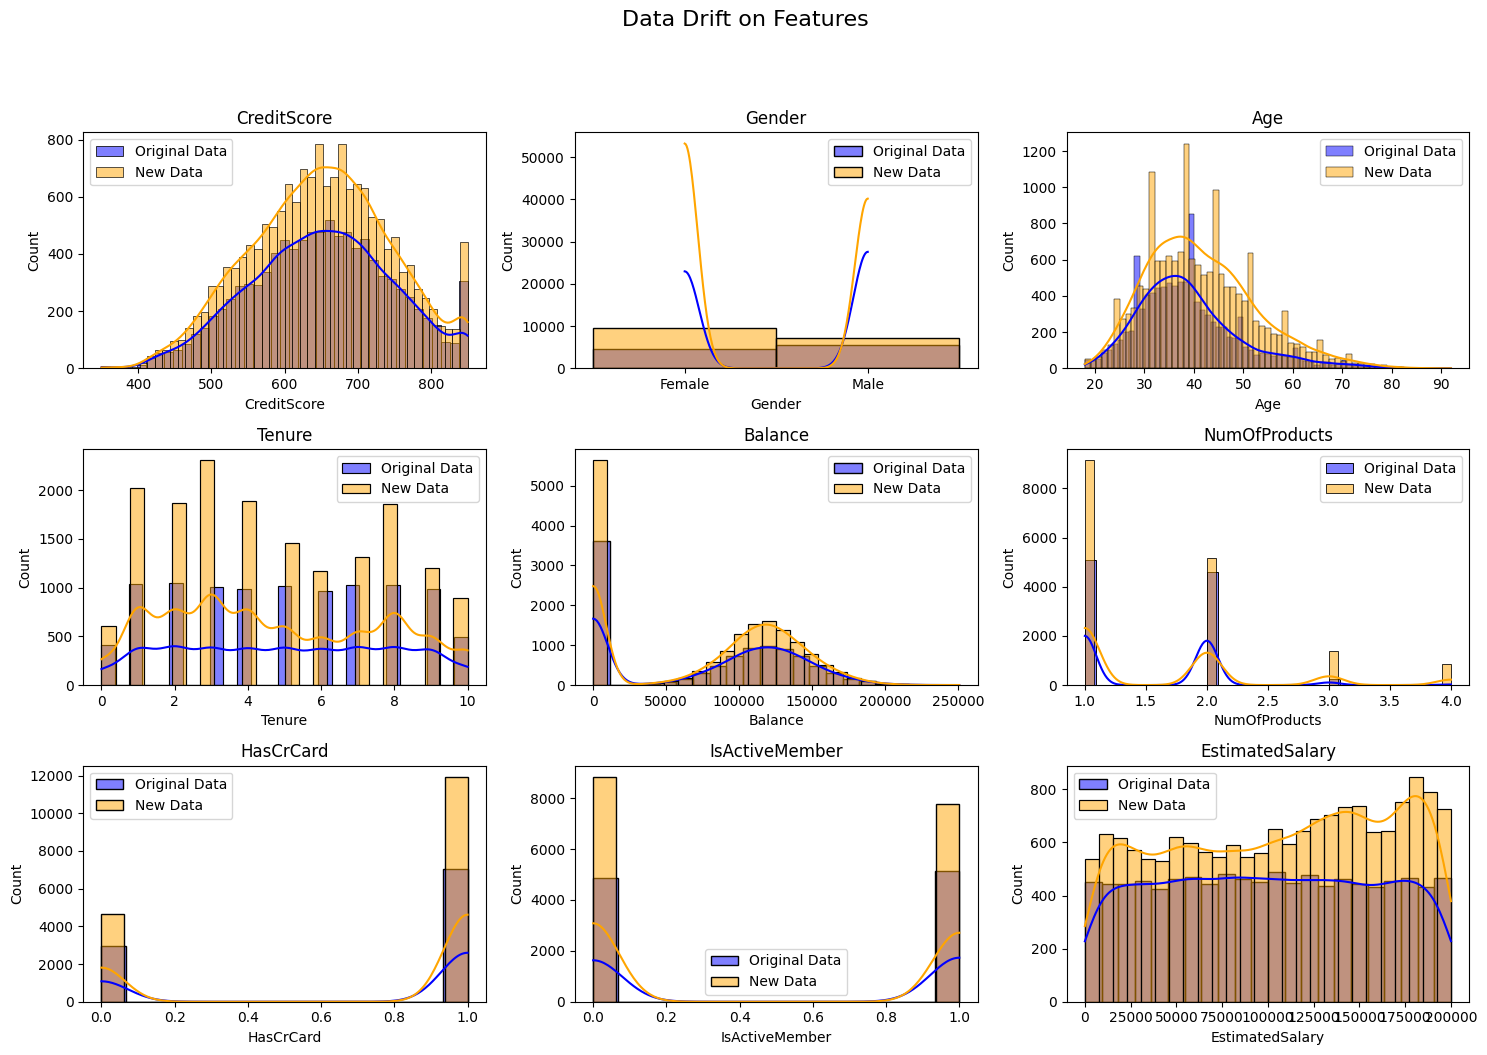

In [31]:
fm.plot_data_drift_on_features(completed_non_norm_df, excluded_cols=['Exited'])